/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The average silhouette_score is : 0.6072155070201589


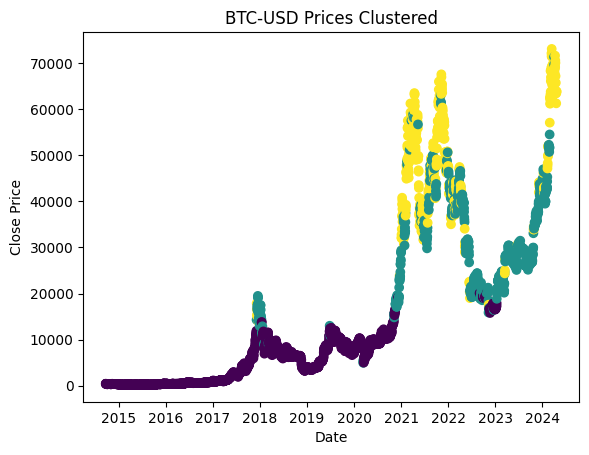

In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

btc_data = pd.read_csv('BTC-USD.csv', parse_dates=['Date'])

# Set the Date as the index
btc_data.set_index('Date', inplace=True)

# 7-day moving average and standard deviation
btc_data['7d_avg'] = btc_data['Close'].rolling(window=7).mean()
btc_data['7d_std'] = btc_data['Close'].rolling(window=7).std()


btc_data.dropna(inplace=True)
features = btc_data[['7d_avg', '7d_std']].values

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
btc_data['cluster'] = kmeans.fit_predict(scaled_features)

# silhouette score
silhouette_avg = silhouette_score(scaled_features, btc_data['cluster'])
print(f"The average silhouette_score is : {silhouette_avg}")

plt.scatter(btc_data.index, btc_data['Close'], c=btc_data['cluster'], cmap='viridis')
plt.title("BTC-USD Prices Clustered")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


In [8]:
btc_data = pd.read_csv('BTC-USD.csv')
print(btc_data.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


Estimated number of clusters: 1
Estimated number of noise points: 5


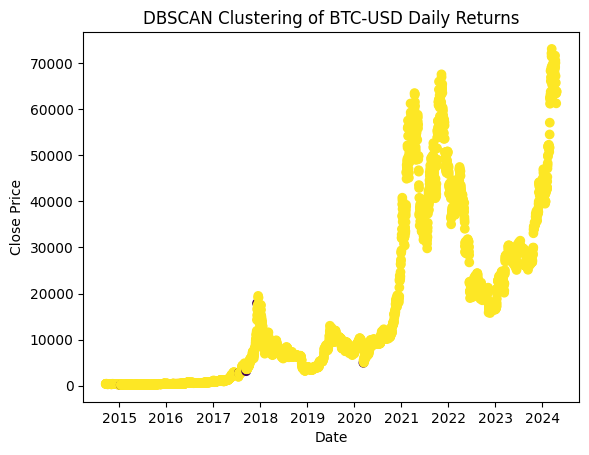

In [13]:
# daily returns
btc_data['Daily_Return'] = btc_data['Close'].pct_change()
btc_data.dropna(inplace=True)

# Reshape the data
X = btc_data['Daily_Return'].values.reshape(-1, 1)

X_scaled = StandardScaler().fit_transform(X)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

btc_data['Cluster'] = clusters

n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

# Plotting the results
import matplotlib.pyplot as plt

plt.scatter(btc_data.index, btc_data['Close'], c=btc_data['Cluster'], cmap='viridis')
plt.title('DBSCAN Clustering of BTC-USD Daily Returns')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


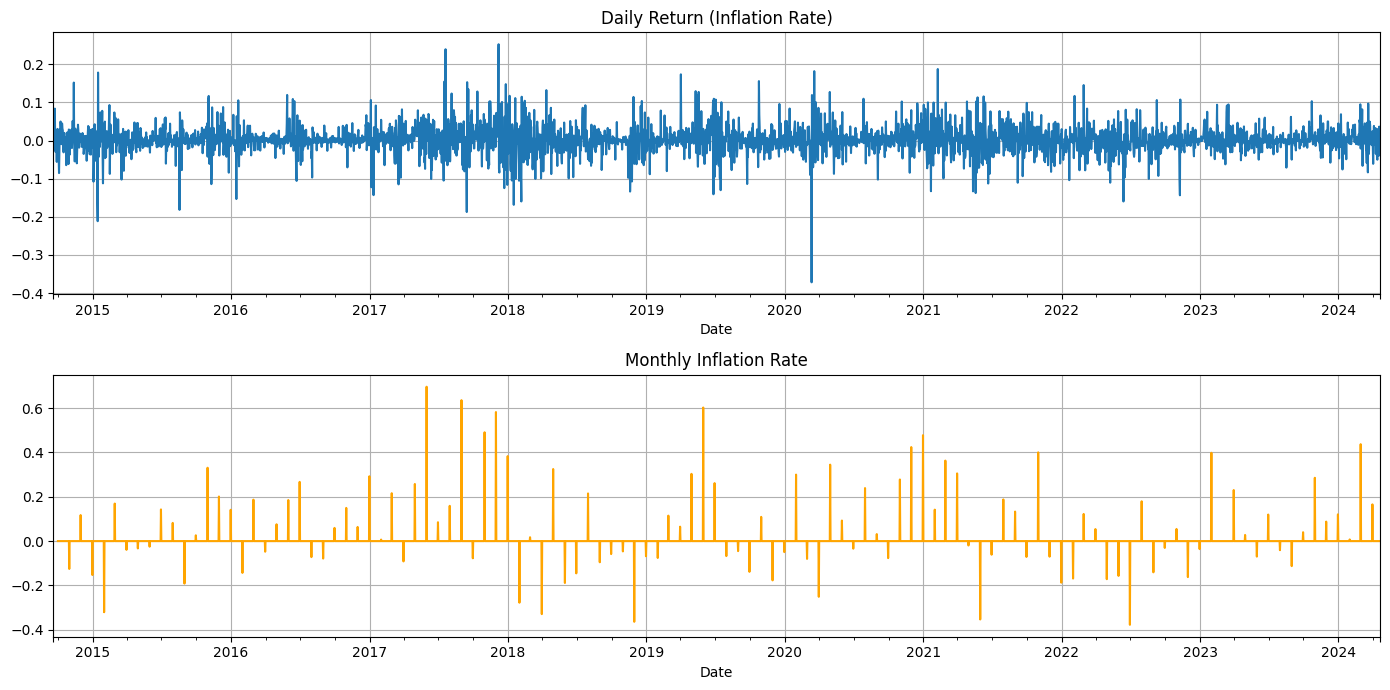

            Monthly_Close  Monthly_Inflation
Date                                        
2024-04-16            NaN                0.0
2024-04-17            NaN                0.0
2024-04-18            NaN                0.0
2024-04-19            NaN                0.0
2024-04-20            NaN                0.0


In [15]:
btc_data['Daily_Return'] = btc_data['Close'].pct_change()

btc_data['Monthly_Close'] = btc_data['Close'].resample('M').last()

# Calculate the monthly inflation rate (monthly price change percentage)
btc_data['Monthly_Inflation'] = btc_data['Monthly_Close'].pct_change()

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
btc_data['Daily_Return'].plot(title='Daily Return (Inflation Rate)', grid=True)

plt.subplot(2, 1, 2)
btc_data['Monthly_Inflation'].plot(title='Monthly Inflation Rate', color='orange', grid=True)
plt.tight_layout()
plt.show()


In [16]:
btc_data['7d_avg'] = btc_data['Close'].rolling(window=7).mean()
btc_data['7d_std'] = btc_data['Close'].rolling(window=7).std()


btc_data.dropna(inplace=True)
features = btc_data[['7d_avg', '7d_std']].values

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

# silhouette score
silhouette_avg = silhouette_score(features_scaled, cluster_labels)
print(f'Silhouette Score: {silhouette_avg}')

# Davies-Bouldin score
davies_bouldin_idx = davies_bouldin_score(features_scaled, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin_idx}')


Silhouette Score: 0.6070300302368301
Davies-Bouldin Index: 0.7169665766461769


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
